In [1]:
import tensorflow as tf
import numpy as np
import math
import time as ti
import matplotlib.pyplot as plt
import os
import helper
%matplotlib inline


In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir


In [3]:

path_cifar = 'cifar-10-batches-py' #data donwloaded from  https://www.cs.toronto.edu/~kriz/cifar.html - CIFAR-10 python version
batch_id = 5
sample_id = 7


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 7:
Image - Min Value: 20 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 3 Name: cat


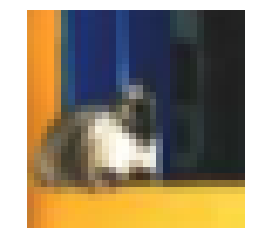

In [4]:
helper.display_stats(path_cifar, batch_id, sample_id)


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 5:
Image - Min Value: 9 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


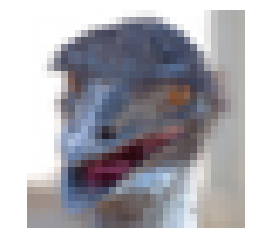

In [5]:
batch_id = 3
sample_id = 5
helper.display_stats(path_cifar, batch_id, sample_id)


# Dataset Classes

The dataset is divided in 5 batches from the CIFAR-10, consisting of 10 different classes listed below:

* airplane
* automobile
* bird 
* cat
* deer
* dog
* frog
* horse
* ship
* truck



In [6]:
def one_hot_encode(labels):
    one_hot = np.zeros((len(labels), 10))
    for label, array in zip(labels, one_hot):
        array[label] = 1
    return one_hot
    
    

In [7]:
def normalize(x):
    
    array = np.array(x)
    max_image = array.max()
    min_image = array.min()
    norm = (array - min_image)/(max_image - min_image)
    return norm
    

In [36]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(path_cifar, normalize, one_hot_encode)

In [37]:
import pickle
#import problem_unittests as tests
import helper

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [38]:
def conv2d_pool(x, outputs, conv_str, conv_ksize, pool_ksi, pool_str):
    _, _, _, deph = x.shape
    weight = tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], deph.value, outputs], 
                                             stddev = 0.015, dtype=tf.float32))
    bias = tf.Variable(tf.zeros([outputs]))
    conv_strides = [1, conv_str[0], conv_str[1], 1]
    conv_ksize = [1, conv_ksize[0], conv_ksize[1], 1]
    pool_ksize = [1, pool_ksi[0], pool_ksi[1], 1]
    pool_stride = [1, pool_str[0], pool_str[1], 1]
    
    conv2d = tf.nn.conv2d(x, weight, conv_strides, padding = 'SAME')
    conv2d_b = tf.add(conv2d, bias)
    conv2d_b_act = tf.nn.relu(conv2d_b)
    conv_pool = tf.nn.max_pool(conv2d_b_act, pool_ksize, pool_stride, padding= 'SAME')
    return conv_pool
    
    
    

In [39]:
def flatten(x):
    return tf.contrib.layers.flatten(x)
    

In [40]:
def fully_connected(x_, outputs):
    
    #outputs is the number of outputs of the new tensor
    #return a 2-D tensor where the second dimension is outputs
    return tf.contrib.layers.fully_connected(inputs=x_, num_outputs=outputs, activation_fn=tf.nn.relu)
 

In [41]:
def final_out(x_, outputs):
    return tf.contrib.layers.fully_connected(inputs=x_, num_outputs=outputs, activation_fn=None)

# Train Neural Network


## Optimization

#### Simply, training neural net
* x for images
* y for labels
* keep_prob for dropout

In [42]:
def train_net(sess, optimizer, keep_probability, xs_batch, ys_batch):
    #training session
    #batch x: images
    #batch y: labels
    
    sess.run(optimizer, feed_dict={x:xs_batch, y: ys_batch, keep_prob:keep_probability})

# Print Stats

In [43]:
def print_stats(sess, xs_batch, ys_batch, loss, accuracy):
    
    loss_ = sess.run(loss, feed_dict={x: xs_batch, y:ys_batch, keep_prob:1.0})
    acc = sess.run(accuracy, feed_dict={x: xs_batch, y:ys_batch, keep_prob:1.0})
    
    print('Loss {} Accuracy {} %'.format(loss_, acc * 100))
    

# Creating a Convolutional Model

In [44]:
def create_conv_net(x, keep_prob):

    #Creates a conv neural net
    #: x: Placeholder with image data
    #: keep_prob: Placeholder holds the keep probability after dropout
    #: output is the logits

    conv_stride = (1,1)
    conv_ksize = (5, 5)
    pool_stride = (2, 2)
    pool_ksize = (2, 2)
    
    conv1_outputs = 32
    conv2_outputs = 64
    conv3_outputs = 128
    full = 512
    #conv_str, conv_ksize, pool_ksi, pool_str
    conv1 = conv2d_pool(x, conv1_outputs, conv_stride, conv_ksize, pool_ksize, pool_stride)
    conv2 = conv2d_pool(conv1, conv2_outputs, conv_stride, conv_ksize, pool_ksize, pool_stride)
    conv3 = conv2d_pool(conv2, conv3_outputs, conv_stride, conv_ksize, pool_ksize, pool_stride)
    
    #flatten layer
    conv3_flatten = flatten(conv3)
    conv3_dropout = tf.nn.dropout(conv3_flatten, keep_prob)
    
    #fully connected layer
    fully = fully_connected(conv3_dropout, full)
    fully_drop = tf.nn.dropout(fully, keep_prob)
    
    #output
    y_convolution = final_out(fully_drop, n_classes)
    return y_convolution
    
    

# Initialize our Neural Net

In [45]:
tf.reset_default_graph()
n_classes = 10
learning_rate = 2e-4
epochs = 30
batch_size = 256
keep_probability = 0.5

# Placeholders for inputs and outoputs

x = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3], name='inputs')
y = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name='outputs')
keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')

#creating our model
logits = create_conv_net(x, keep_prob)

#naming variable
logits = tf.identity(logits, name='logits')

# loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# accuracy
prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32), name='accuracy')




In [46]:
save_model_path = './image_classification'


In [51]:
print("Initialize training")
import time as tp
start = tp.time()
try:
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        for epoch in range(epochs):
            n_batches = 5
            for batch in range(1, n_batches + 1):
                for xs_batch, ys_batch in helper.load_preprocess_training_batch(batch, batch_size):
                    train_net(sess, optimizer, keep_probability, xs_batch, ys_batch)
                print('Epoch {}, CIFAR-10 Batch {}:'.format(epoch + 1, batch))
                print_stats(sess, xs_batch, ys_batch, loss, accuracy)
        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(sess, save_model_path)            
except KeyboardInterrupt:
    print ('Training Interrupted {} minutes'.format((tp.time() - start)//60))



Initialize training
Epoch 1, CIFAR-10 Batch 1:
Loss 2.216984272003174 Accuracy 15.000000596046448 %
Epoch 1, CIFAR-10 Batch 2:
Loss 2.10894775390625 Accuracy 32.50000178813934 %
Epoch 1, CIFAR-10 Batch 3:
Loss 1.8059405088424683 Accuracy 34.99999940395355 %
Epoch 1, CIFAR-10 Batch 4:
Loss 1.8079770803451538 Accuracy 25.0 %
Epoch 1, CIFAR-10 Batch 5:
Loss 1.861507534980774 Accuracy 27.500000596046448 %
Epoch 2, CIFAR-10 Batch 1:
Loss 1.933701992034912 Accuracy 37.5 %
Epoch 2, CIFAR-10 Batch 2:
Loss 1.9096662998199463 Accuracy 39.99999761581421 %
Epoch 2, CIFAR-10 Batch 3:
Loss 1.4683904647827148 Accuracy 44.999998807907104 %
Epoch 2, CIFAR-10 Batch 4:
Loss 1.588769555091858 Accuracy 40.00000357627869 %
Epoch 2, CIFAR-10 Batch 5:
Loss 1.6288187503814697 Accuracy 42.500001192092896 %
Epoch 3, CIFAR-10 Batch 1:
Loss 1.7551279067993164 Accuracy 44.999998807907104 %
Epoch 3, CIFAR-10 Batch 2:
Loss 1.8027806282043457 Accuracy 39.99999761581421 %
Epoch 3, CIFAR-10 Batch 3:
Loss 1.2793433666229

Epoch 21, CIFAR-10 Batch 5:
Loss 0.3795355558395386 Accuracy 94.9999988079071 %
Epoch 22, CIFAR-10 Batch 1:
Loss 0.49625641107559204 Accuracy 82.50000476837158 %
Epoch 22, CIFAR-10 Batch 2:
Loss 0.3796396851539612 Accuracy 92.5000011920929 %
Epoch 22, CIFAR-10 Batch 3:
Loss 0.3418569564819336 Accuracy 94.9999988079071 %
Epoch 22, CIFAR-10 Batch 4:
Loss 0.42240291833877563 Accuracy 90.00000357627869 %
Epoch 22, CIFAR-10 Batch 5:
Loss 0.35687360167503357 Accuracy 94.9999988079071 %
Epoch 23, CIFAR-10 Batch 1:
Loss 0.4432607591152191 Accuracy 85.00000238418579 %
Epoch 23, CIFAR-10 Batch 2:
Loss 0.38381144404411316 Accuracy 94.9999988079071 %
Epoch 23, CIFAR-10 Batch 3:
Loss 0.31639131903648376 Accuracy 94.9999988079071 %
Epoch 23, CIFAR-10 Batch 4:
Loss 0.41513851284980774 Accuracy 94.9999988079071 %
Epoch 23, CIFAR-10 Batch 5:
Loss 0.3241739273071289 Accuracy 94.9999988079071 %
Epoch 24, CIFAR-10 Batch 1:
Loss 0.38807421922683716 Accuracy 87.50000596046448 %
Epoch 24, CIFAR-10 Batch 2:
L

# Test Model

In [56]:
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'

n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('inputs:0')
        loaded_y = loaded_graph.get_tensor_by_name('outputs:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        #random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        #random_test_predictions = sess.run(
            #tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            #feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        #helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.739131435751915

